# Keyword Correlation Analysis (EQA Subset)

This notebook evaluates **keyword–label correlations** across 40+ misinformation datasets from the
**ComplexDataLab/Misinfo_Datasets** collection. The analysis follows the methodology proposed in:

[Thibault et al., “A Guide to Misinformation Detection Data and Evaluation,” KDD 2025.](https://arxiv.org/abs/2411.05060)

The goal is to detect **lexical shortcuts**, situations where a small set of keywords strongly predicts the label,
indicating that models may succeed for the *wrong reasons* (dataset bias) rather than actual fact-checking ability.

This is part of the EQA (Evaluation Quality Assessment) suite:
- Keyword correlations  
- Temporal shortcuts  
- Feasibility checks  

In this notebook, we run the **keyword shortcut detector** for datasets that might be useful for our experiments and compare each dataset's
keyword-based classifier to a random baseline.


In [ ]:
import pandas as pd
import numpy as np
import string
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from typing import Any
import nltk
from datasets import load_dataset

nltk.download("punkt")
nltk.download('punkt_tab')
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### What the Keyword Analysis Script Does

The `keyword_analysis()` function provided by the Misinfo_Datasets creators performs the following steps:

1. **Filters labels**  
   Keeps only binary labels (`true`, `false`), removing `unknown/mixed`.

2. **Text preprocessing**  
   - Lowercasing  
   - Removing punctuation  
   - Tokenizing  
   - Removing English stopwords  

3. **Keyword extraction**  
   Computes the **40 most frequent words** across all claims.

4. **Binary bag-of-words representation**  
   Each claim becomes a 40-dimensional binary vector indicating presence/absence of each keyword.

5. **Classifier**  
   Trains a **Random Forest** on this minimal keyword representation.

6. **Comparison to random baseline**  
   Evaluates the macro-F1 of:
   - the keyword-classifier  
   - a random label predictor based on class proportions  

A high RandomForest F1 score (especially > 60%) suggests that **a small set of keywords alone explains most of the labels**, which is a strong sign of dataset bias.

[Github Link](https://github.com/ComplexData-MILA/misinfo-datasets/blob/main/misinfo_data_eval/tasks/keyword_analysis.py)

In [ ]:
LABEL_MAP = {"true": 1, "false": 0, "unknown": None}

In [ ]:
def keyword_analysis(dataset: list[dict[str, Any]]) -> dict[str, float]:
    """
    Processes a dataset to analyze veracity distribution, top keywords, and train a classifier.

    Parameters:
        data (pd.DataFrame or np.ndarray): A 2D dataset with "dataset", "claim", and "veracity" columns.
        dataset_name (str): The name of the dataset to process.

    Returns:
        dict: A dictionary containing veracity counts, top keywords, confusion matrix, and F1 scores.
    """

    # Convert to DataFrame if input is NumPy array
    temp_df = pd.DataFrame(dataset)


    # exclude all but T/F (TODO: Add if statement to include 'mixed' values)
    temp_df = temp_df[temp_df.veracity != 3]
    temp_df["veracity"] = temp_df["veracity"].apply(LABEL_MAP.get)
    temp_df = temp_df[temp_df.veracity.notna()]
    temp_df = temp_df[temp_df["veracity"].isin([0, 1])] # Keep only 0 and 1 labels
    temp_df["veracity"] = temp_df["veracity"].astype(int)
    print("len(dataset) filtered by veracity is not unknown:", len(temp_df))

    # Eventual overwrite
    df = temp_df

    # Veracity Label Distribution
    label_counts = df["veracity"].value_counts().to_dict()
    label_props = (df["veracity"].value_counts(normalize=True) * 100).to_dict()

    # Text Preprocessing Function
    stop_words = set(stopwords.words("english"))
    def preprocess_text(text):
        text = text.lower()
        text = text.translate(str.maketrans("", "", string.punctuation))
        words = word_tokenize(text)
        words = [word for word in words if word not in stop_words]
        return words

    df["processed_claims"] = df["claim"].apply(preprocess_text)

    # Top 40 Keywords
    all_words = [word for claim in df["processed_claims"] for word in claim]
    word_counts = Counter(all_words).most_common(40)
    top_keywords = {word: count for word, count in word_counts}

    # Convert Claims to Features (Bag-of-Words)
    word_features = list(top_keywords.keys())
    def claim_to_vector(words):
        return [1 if word in words else 0 for word in word_features]

    X = np.array(df["processed_claims"].apply(claim_to_vector).tolist())
    y = df["veracity"].values

    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    # Train Random Forest Model
    rf_model = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42)
    rf_model.fit(X_train, y_train)

    # Predict & Evaluate
    y_pred = rf_model.predict(X_test)
    conf_matrix = confusion_matrix(y_test, y_pred).tolist()  # Convert to list for JSON compatibility
    macro_f1 = f1_score(y_test, y_pred, average="macro")

    # Baseline Random Predictions
    random_preds = np.random.choice(np.unique(y_train), size=len(y_test), p=np.bincount(y_train) / len(y_train))
    baseline_f1 = f1_score(y_test, random_preds, average="macro")

    # Return results as a dictionary
    return {
        "veracity_counts": label_counts,
        "veracity_proportions": label_props,
        "top_keywords": top_keywords,
        "confusion_matrix": conf_matrix,
        "macro_f1_random_forest": macro_f1,
        "macro_f1_random_baseline": baseline_f1
    }

In [ ]:
DATASET_NAMES = [
    "IFND",
    "antivax",
    #"banfakenews",
    #"benjamin_political_news",
    #"celebrity",
    "checkcovid",
    "claimskg",
    "climate_fever",
    "cmu_miscov19",
    "coaid",
    #"counter-covid-19-misinformation",
    #"covid-19-disinformation",
    "covid_19_rumor",
    #"covid_vaccine_misinfo_mic",
    "covidfact",
    #"ct_fan",
    "defakts",
    #"esoc",
    #"fa_kes",
    "fake_news_corpus",
    "fakecovid",
    #"fakenewsamt",
    "faviq",
    "fever",
    "feverous",
    "fibvid",
    "hover",
    #"isot_fake_news",
    "liar",
    "liar_new",
    "mediaeval",
    "mm-covid",
    #"multiclaim",
    "nlp4if",
    #"pheme",
    "pubhealthtab",
    "rumors",
    "snopes",
    #"ti_cnn",
    "truthseeker2023",
    "twitter15",
    "twitter16",
    "verite",
    "wico",
    "x_fact",
]

# DATASET_NAMES = ["mediaeval", "x_fact", "fever", "climate_fever", "IFND"]

### Running Keyword Analysis Across All Datasets

We loop over datasets in Misinfo_Datasets that might be useful for our experiments and run the keyword-analysis pipeline on each one.
Whenever `train`, `validation`, or `test` splits exist, they are concatenated and treated as a single dataset.

This gives us:
- **label distribution per dataset**  
- **top 40 keywords**  
- **macro-F1 of the keyword-based classifier**  
- **macro-F1 of the random baseline**  
- **confusion matrix**

These metrics allow us to identify **which datasets contain strong lexical shortcuts**.


In [ ]:
results_by_dataset = {}

for name in DATASET_NAMES:
    print(f"\nKeyword Analysis on {name} ...")
    ds = load_dataset("ComplexDataLab/Misinfo_Datasets", name)

    available_splits = [split for split in ["train", "validation", "test"] if split in ds]
    if not available_splits:
        print(f"{name}, skipping.")
        continue

    frames = [ds[split].to_pandas() for split in available_splits]
    combined_df = pd.concat(frames, ignore_index=True)
    records = combined_df.to_dict(orient="records")
    res = keyword_analysis(records)
    results_by_dataset[name] = res


Keyword Analysis on IFND ...
len(dataset) filtered by veracity is not unknown: 56698

Keyword Analysis on antivax ...


antivax/antivax_train.parquet:   0%|          | 0.00/297k [00:00<?, ?B/s]

antivax/antivax_test.parquet:   0%|          | 0.00/138k [00:00<?, ?B/s]

antivax/antivax_validation.parquet:   0%|          | 0.00/106k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/10551 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3015 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1507 [00:00<?, ? examples/s]

len(dataset) filtered by veracity is not unknown: 15073

Keyword Analysis on checkcovid ...


checkcovid/checkcovid_train.parquet:   0%|          | 0.00/130k [00:00<?, ?B/s]

checkcovid/checkcovid_test.parquet:   0%|          | 0.00/99.2k [00:00<?, ?B/s]

checkcovid/checkcovid_validation.parquet:   0%|          | 0.00/89.3k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1390 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/398 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/198 [00:00<?, ? examples/s]

len(dataset) filtered by veracity is not unknown: 1491

Keyword Analysis on claimskg ...


claimskg/claimskg_train.parquet:   0%|          | 0.00/104M [00:00<?, ?B/s]

claimskg/claimskg_test.parquet:   0%|          | 0.00/29.4M [00:00<?, ?B/s]

claimskg/claimskg_validation.parquet:   0%|          | 0.00/15.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/46945 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/13413 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/6707 [00:00<?, ? examples/s]

len(dataset) filtered by veracity is not unknown: 52153

Keyword Analysis on climate_fever ...
len(dataset) filtered by veracity is not unknown: 5305

Keyword Analysis on cmu_miscov19 ...


cmu_miscov19/cmu_miscov19_train.parquet:   0%|          | 0.00/144k [00:00<?, ?B/s]

cmu_miscov19/cmu_miscov19_test.parquet:   0%|          | 0.00/94.9k [00:00<?, ?B/s]

cmu_miscov19/cmu_miscov19_validation.par(…):   0%|          | 0.00/85.0k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3201 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/915 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/457 [00:00<?, ? examples/s]

len(dataset) filtered by veracity is not unknown: 1761

Keyword Analysis on coaid ...


coaid/coaid_train.parquet:   0%|          | 0.00/5.97M [00:00<?, ?B/s]

coaid/coaid_test.parquet:   0%|          | 0.00/2.53M [00:00<?, ?B/s]

coaid/coaid_validation.parquet:   0%|          | 0.00/1.64M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/195143 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/55757 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/27878 [00:00<?, ? examples/s]

len(dataset) filtered by veracity is not unknown: 278778

Keyword Analysis on covid_19_rumor ...


covid_19_rumor/covid_19_rumor_train.parq(…):   0%|          | 0.00/673k [00:00<?, ?B/s]

covid_19_rumor/covid_19_rumor_test.parqu(…):   0%|          | 0.00/253k [00:00<?, ?B/s]

covid_19_rumor/covid_19_rumor_validation(…):   0%|          | 0.00/168k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5025 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1436 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/718 [00:00<?, ? examples/s]

len(dataset) filtered by veracity is not unknown: 5559

Keyword Analysis on covidfact ...


covidfact/covidfact_train.parquet:   0%|          | 0.00/611k [00:00<?, ?B/s]

covidfact/covidfact_test.parquet:   0%|          | 0.00/326k [00:00<?, ?B/s]

covidfact/covidfact_validation.parquet:   0%|          | 0.00/222k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2860 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/818 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/408 [00:00<?, ? examples/s]

len(dataset) filtered by veracity is not unknown: 4086

Keyword Analysis on defakts ...


defakts/defakts_train.parquet:   0%|          | 0.00/13.3M [00:00<?, ?B/s]

defakts/defakts_test.parquet:   0%|          | 0.00/3.85M [00:00<?, ?B/s]

defakts/defakts_validation.parquet:   0%|          | 0.00/1.99M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/74098 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/21172 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10585 [00:00<?, ? examples/s]

len(dataset) filtered by veracity is not unknown: 20008

Keyword Analysis on fake_news_corpus ...


fake_news_corpus/fake_news_corpus_train.(…):   0%|          | 0.00/606k [00:00<?, ?B/s]

fake_news_corpus/fake_news_corpus_test.p(…):   0%|          | 0.00/247k [00:00<?, ?B/s]

fake_news_corpus/fake_news_corpus_valida(…):   0%|          | 0.00/201k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/175 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/25 [00:00<?, ? examples/s]

len(dataset) filtered by veracity is not unknown: 201

Keyword Analysis on fakecovid ...


fakecovid/fakecovid_train.parquet:   0%|          | 0.00/20.6M [00:00<?, ?B/s]

fakecovid/fakecovid_test.parquet:   0%|          | 0.00/5.71M [00:00<?, ?B/s]

fakecovid/fakecovid_validation.parquet:   0%|          | 0.00/2.96M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5336 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1525 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/762 [00:00<?, ? examples/s]

len(dataset) filtered by veracity is not unknown: 3255

Keyword Analysis on faviq ...


faviq/faviq_train.parquet:   0%|          | 0.00/134M [00:00<?, ?B/s]

faviq/faviq_test.parquet:   0%|          | 0.00/38.5M [00:00<?, ?B/s]

faviq/faviq_validation.parquet:   0%|          | 0.00/19.4M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/128581 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/36738 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/18369 [00:00<?, ? examples/s]

len(dataset) filtered by veracity is not unknown: 183688

Keyword Analysis on fever ...
len(dataset) filtered by veracity is not unknown: 123142

Keyword Analysis on feverous ...


feverous/feverous_train.parquet:   0%|          | 0.00/6.51M [00:00<?, ?B/s]

feverous/feverous_test.parquet:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

feverous/feverous_validation.parquet:   0%|          | 0.00/1.00M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/55427 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/15838 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/7918 [00:00<?, ? examples/s]

len(dataset) filtered by veracity is not unknown: 76439

Keyword Analysis on fibvid ...


fibvid/fibvid_train.parquet:   0%|          | 0.00/365k [00:00<?, ?B/s]

fibvid/fibvid_test.parquet:   0%|          | 0.00/170k [00:00<?, ?B/s]

fibvid/fibvid_validation.parquet:   0%|          | 0.00/125k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1982 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/567 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/283 [00:00<?, ? examples/s]

len(dataset) filtered by veracity is not unknown: 2832

Keyword Analysis on hover ...


hover/hover_train.parquet:   0%|          | 0.00/1.79M [00:00<?, ?B/s]

hover/hover_test.parquet:   0%|          | 0.00/708k [00:00<?, ?B/s]

hover/hover_validation.parquet:   0%|          | 0.00/416k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/18319 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5235 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2617 [00:00<?, ? examples/s]

len(dataset) filtered by veracity is not unknown: 22171

Keyword Analysis on liar ...


liar/liar_train.parquet:   0%|          | 0.00/1.20M [00:00<?, ?B/s]

liar/liar_test.parquet:   0%|          | 0.00/327k [00:00<?, ?B/s]

liar/liar_validation.parquet:   0%|          | 0.00/306k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4345 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1242 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/621 [00:00<?, ? examples/s]

len(dataset) filtered by veracity is not unknown: 6204

Keyword Analysis on liar_new ...


liar_new/liar_new_train.parquet:   0%|          | 0.00/298k [00:00<?, ?B/s]

liar_new/liar_new_test.parquet:   0%|          | 0.00/139k [00:00<?, ?B/s]

liar_new/liar_new_validation.parquet:   0%|          | 0.00/110k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1369 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/392 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/196 [00:00<?, ? examples/s]

len(dataset) filtered by veracity is not unknown: 1957

Keyword Analysis on mediaeval ...
len(dataset) filtered by veracity is not unknown: 40366

Keyword Analysis on mm-covid ...


mm-covid/mm-covid_train.parquet:   0%|          | 0.00/480k [00:00<?, ?B/s]

mm-covid/mm-covid_test.parquet:   0%|          | 0.00/198k [00:00<?, ?B/s]

mm-covid/mm-covid_validation.parquet:   0%|          | 0.00/140k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5196 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1485 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/742 [00:00<?, ? examples/s]

len(dataset) filtered by veracity is not unknown: 7423

Keyword Analysis on nlp4if ...


nlp4if/nlp4if_train.parquet:   0%|          | 0.00/801k [00:00<?, ?B/s]

nlp4if/nlp4if_test.parquet:   0%|          | 0.00/180k [00:00<?, ?B/s]

nlp4if/nlp4if_validation.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2220 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/635 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/317 [00:00<?, ? examples/s]

len(dataset) filtered by veracity is not unknown: 2144

Keyword Analysis on pubhealthtab ...


pubhealthtab/pubhealthtab_train.parquet:   0%|          | 0.00/203k [00:00<?, ?B/s]

pubhealthtab/pubhealthtab_test.parquet:   0%|          | 0.00/130k [00:00<?, ?B/s]

pubhealthtab/pubhealthtab_validation.par(…):   0%|          | 0.00/111k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1359 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/389 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/194 [00:00<?, ? examples/s]

len(dataset) filtered by veracity is not unknown: 1481

Keyword Analysis on rumors ...


rumors/rumors_train.parquet:   0%|          | 0.00/1.81M [00:00<?, ?B/s]

rumors/rumors_test.parquet:   0%|          | 0.00/614k [00:00<?, ?B/s]

rumors/rumors_validation.parquet:   0%|          | 0.00/340k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/865 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/248 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/123 [00:00<?, ? examples/s]

len(dataset) filtered by veracity is not unknown: 850

Keyword Analysis on snopes ...


snopes/snopes_train.parquet:   0%|          | 0.00/9.05M [00:00<?, ?B/s]

snopes/snopes_test.parquet:   0%|          | 0.00/2.64M [00:00<?, ?B/s]

snopes/snopes_validation.parquet:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3185 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/910 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/455 [00:00<?, ? examples/s]

len(dataset) filtered by veracity is not unknown: 3476

Keyword Analysis on truthseeker2023 ...


truthseeker2023/truthseeker2023_train.pa(…):   0%|          | 0.00/12.6M [00:00<?, ?B/s]

truthseeker2023/truthseeker2023_test.par(…):   0%|          | 0.00/3.85M [00:00<?, ?B/s]

truthseeker2023/truthseeker2023_validati(…):   0%|          | 0.00/2.07M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/93938 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/26840 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13420 [00:00<?, ? examples/s]

len(dataset) filtered by veracity is not unknown: 134198

Keyword Analysis on twitter15 ...


twitter15/twitter15_train.parquet:   0%|          | 0.00/139k [00:00<?, ?B/s]

twitter15/twitter15_test.parquet:   0%|          | 0.00/94.6k [00:00<?, ?B/s]

twitter15/twitter15_validation.parquet:   0%|          | 0.00/85.3k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1043 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/298 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/149 [00:00<?, ? examples/s]

len(dataset) filtered by veracity is not unknown: 1116

Keyword Analysis on twitter16 ...


twitter16/twitter16_train.parquet:   0%|          | 0.00/109k [00:00<?, ?B/s]

twitter16/twitter16_test.parquet:   0%|          | 0.00/85.7k [00:00<?, ?B/s]

twitter16/twitter16_validation.parquet:   0%|          | 0.00/80.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/572 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/164 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/82 [00:00<?, ? examples/s]

len(dataset) filtered by veracity is not unknown: 617

Keyword Analysis on verite ...


verite/verite_train.parquet:   0%|          | 0.00/122k [00:00<?, ?B/s]

verite/verite_test.parquet:   0%|          | 0.00/92.8k [00:00<?, ?B/s]

verite/verite_validation.parquet:   0%|          | 0.00/84.1k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/700 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/201 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/100 [00:00<?, ? examples/s]

len(dataset) filtered by veracity is not unknown: 1001

Keyword Analysis on wico ...


wico/wico_train.parquet:   0%|          | 0.00/218k [00:00<?, ?B/s]

wico/wico_test.parquet:   0%|          | 0.00/116k [00:00<?, ?B/s]

wico/wico_validation.parquet:   0%|          | 0.00/95.3k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/6779 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1937 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/969 [00:00<?, ? examples/s]

len(dataset) filtered by veracity is not unknown: 9685

Keyword Analysis on x_fact ...
len(dataset) filtered by veracity is not unknown: 33921


### Interpreting the Keyword-Based Macro-F1 Scores

For each dataset, we plot:
- **RandomForest keyword classifier macro-F1**
- **Random baseline macro-F1**
- A reference line at **50%**

Interpretation guidelines:

- **> 60–70% macro-F1** using only 40 keywords  
  → Strong lexical shortcuts (dataset may be biased).  
- **40–55% macro-F1**  
  → Moderate keyword association; some artifacts present.  
- **< 35% macro-F1**  
  → Weak keyword associations; dataset likely more balanced.  

Datasets in **red exceed the shortcut threshold we use in this notebook (55%)**, indicating potential bias.
Green bars indicate datasets where keyword correlations are weaker.


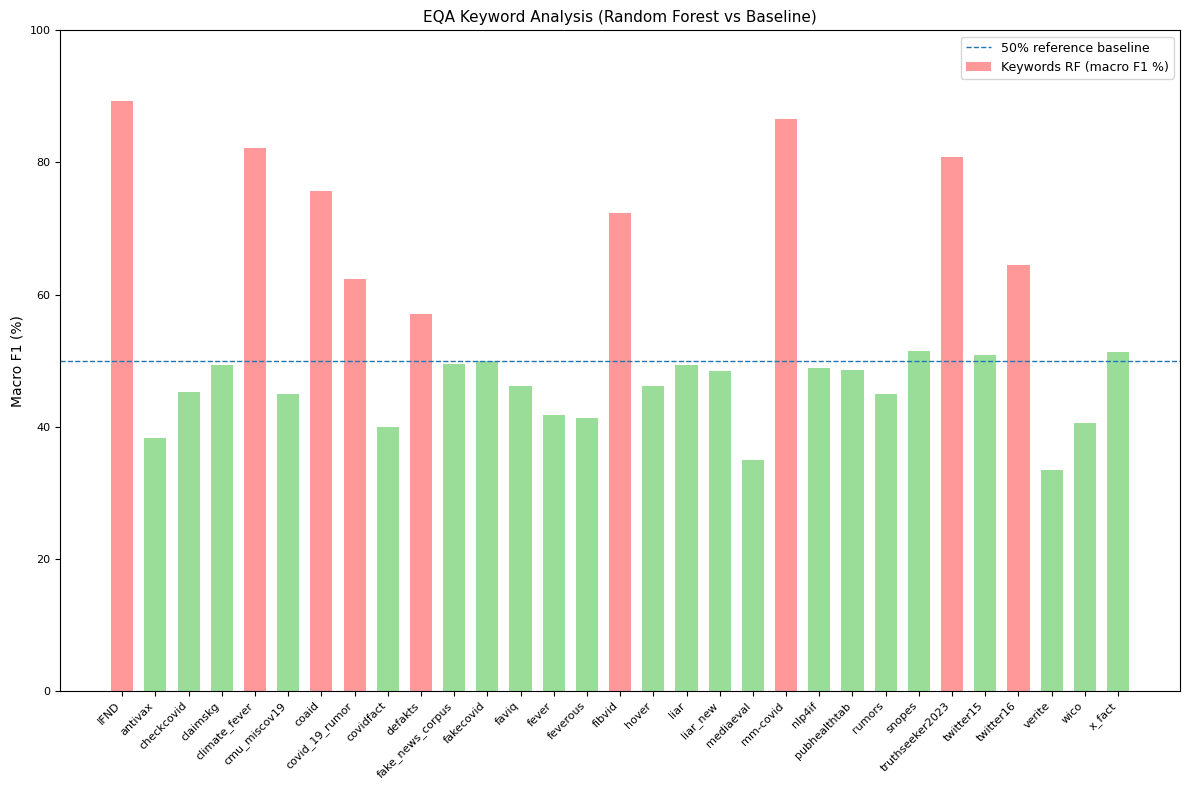

In [ ]:
import matplotlib.pyplot as plt

datasets = list(results_by_dataset.keys())

rf_scores = [
    results_by_dataset[name]["macro_f1_random_forest"] * 100
    for name in datasets
]
baseline_scores = [
    results_by_dataset[name]["macro_f1_random_baseline"] * 100
    for name in datasets
]

x = np.arange(len(datasets)) * 0.3
width = 0.2

plt.figure(figsize=(12, 8))

pastel_red   = "#ff9999"
pastel_green = "#99dd99"

colors = [
    pastel_red if score > 55 else pastel_green
    for score in rf_scores
]

plt.bar(x, rf_scores, width=width, label="Keywords RF (macro F1 %)", color=colors)

plt.axhline(50, linestyle="--", linewidth=1, label="50% reference baseline")

plt.xticks(x, datasets, rotation=45, ha="right", fontsize=8)
plt.yticks(fontsize=8)
plt.ylabel("Macro F1 (%)", fontsize=10)
#plt.xlabel("Dataset", fontsize=10)
plt.ylim(0, 100)
plt.title("EQA Keyword Analysis (Random Forest vs Baseline)", fontsize=11)
plt.legend(fontsize=9)
plt.tight_layout()


plt.show()

### Findings and Dataset-Specific Insights

The results reveal substantial variation across datasets in how strongly labels correlate with a small set of keywords.

**High-scoring / shortcut-heavy datasets (red bars):**
These datasets achieve **>60% macro-F1** using just 40 keywords.  
Examples include:
- IFND    
- Climate-FEVER  
- Defacts  
- FibVID  

This indicates **strong lexical shortcuts**, meaning models can perform well by memorizing dataset-specific vocabulary rather than reasoning.

**Medium-scoring datasets (40–55%)**  
Moderate keyword correlation; still some bias, but more mixed:
- FEVER  
- FEVEROUS  
- X-FACT   

These datasets are **challenging** but less dominated by simple cues.

**Low-scoring datasets (<40%)**  
Little lexical bias; models must rely on semantic/structural understanding.

---

### How This Relates to Our Main Project

These findings directly support the results in our misinformation detection experiments:

- **Climate-FEVER** shows very high keyword correlation, explaining why Complement Naive Bayes achieves ~0.80 macro-F1 in our experiments.  
  Performance comes partly from **dataset artifacts**, not only genuine reasoning.

- **FEVER** and **X-FACT** show moderate lexical correlation, whivh aligns with low-to-mid macro-F1 (0.50–0.64) in claim-only settings.  
  These datasets are inherently **harder** and require stronger models (like XLM-R).

- **X-FACT** especially is not keyword-dominated, confirming that claim-only multilingual misinformation detection is a **genuinely difficult task**, matching the low macro-F1 scores in our cross-lingual experiments.

This keyword analysis validates our claim that:
> *Evidence quality, dataset artifacts, and label imbalance strongly affect misinformation model performance.*
